In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import dibuja_covar

plt.style.use('ggplot')

In [137]:
# Cargamos los datos
precios_pos_df = pd.read_csv('../data/precios_corr_pos.csv', index_col=0, parse_dates=True)
precios_neg_df = pd.read_csv('../data/precios_corr_neg.csv', index_col=0, parse_dates=True)
precios_cero_df = pd.read_csv('../data/precios_corr_cero.csv', index_col=0, parse_dates=True)

In [139]:
precios_df = pd.concat([precios_pos_df, precios_neg_df, precios_cero_df], axis=1)

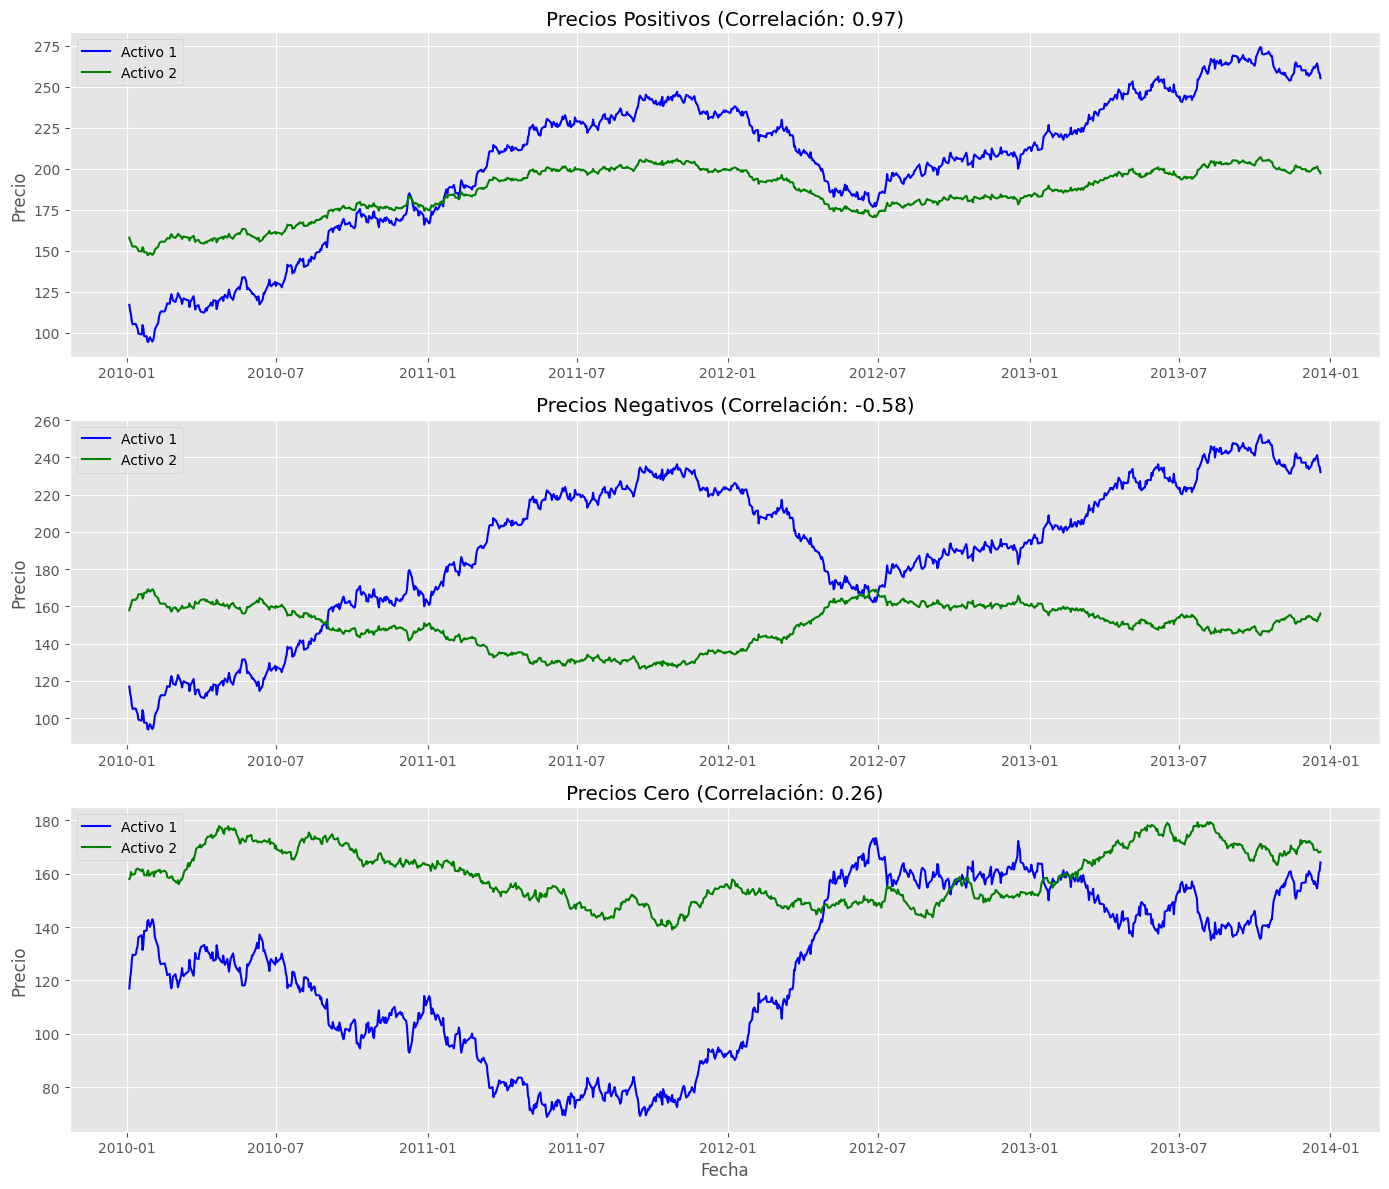

In [149]:
# Inicializar figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Graficar precios_pos_df y mostrar coeficiente de correlación en el título
corr_pos = precios_pos_df.corr().iloc[0, 1]
axes[0].plot(precios_pos_df['Activo 1'], label='Activo 1', color='blue')
axes[0].plot(precios_pos_df['Activo 2'], label='Activo 2', color='green')
axes[0].set_title(f'Precios Positivos (Correlación: {corr_pos:.2f})')
axes[0].set_ylabel('Precio')
axes[0].legend()
axes[0].grid(True)

# Graficar precios_neg_df y mostrar coeficiente de correlación en el título
corr_neg = precios_neg_df.corr().iloc[0, 1]
axes[1].plot(precios_neg_df['Activo 1'], label='Activo 1', color='blue')
axes[1].plot(precios_neg_df['Activo 2'], label='Activo 2', color='green')
axes[1].set_title(f'Precios Negativos (Correlación: {corr_neg:.2f})')
axes[1].set_ylabel('Precio')
axes[1].legend()
axes[1].grid(True)

# Graficar precios_cero_df y mostrar coeficiente de correlación en el título
corr_cero = precios_cero_df.corr().iloc[0, 1]
axes[2].plot(precios_cero_df['Activo 1'], label='Activo 1', color='blue')
axes[2].plot(precios_cero_df['Activo 2'], label='Activo 2', color='green')
axes[2].set_title(f'Precios Cero (Correlación: {corr_cero:.2f})')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Precio')
axes[2].legend()
axes[2].grid(True)

# Mostrar la figura
plt.tight_layout()
plt.show()


In [150]:
# Calcular los retornos logarítmicos para precios_pos_df
retornos_pos_df = np.log(precios_pos_df / precios_pos_df.shift(1)).dropna()

# Calcular los retornos logarítmicos para precios_neg_df
retornos_neg_df = np.log(precios_neg_df / precios_neg_df.shift(1)).dropna()

# Calcular los retornos logarítmicos para precios_cero_df
retornos_cero_df = np.log(precios_cero_df / precios_cero_df.shift(1)).dropna()


<Axes: title={'center': 'Precios de los activos'}>

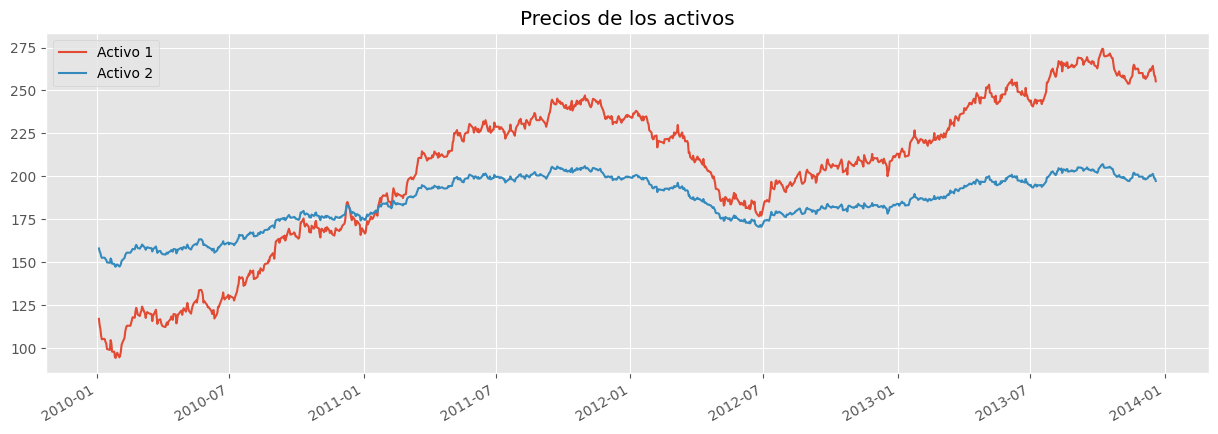

In [147]:
precios_pos_df.plot(figsize=(15, 5), title='Precios de los activos')

In [151]:
# Generar pesos aleatorios
num_portfolios = 100
np.random.seed(42)  # Fijar semilla para reproducibilidad
weights = np.random.random(size=(num_portfolios, 2))
weights = weights / np.sum(weights, axis=1)[:, np.newaxis]  # Normalizar para que la suma sea 1

In [155]:
# Función para calcular rentabilidad y riesgo de un activo individual
def asset_performance(returns):
    return returns.mean(), returns.std()

In [156]:
# Función para calcular retornos, rentabilidad y riesgo de la cartera
def portfolio_performance(weights, returns):
    portfolio_returns = returns.dot(weights.T)
    return portfolio_returns.mean(axis=0), portfolio_returns.std(axis=0)

In [167]:
# Función para graficar en un eje específico
def plot_on_axis(ax, ret_mean, ret_std, asset1_mean, asset1_std, asset2_mean, asset2_std, color, marker, label, corr):
    ax.scatter(ret_std, ret_mean, c=color, marker=marker, alpha=0.4, label=label)
    ax.scatter(asset1_std, asset1_mean, c='red', marker='*', s=150, label='Activo 1')
    ax.scatter(asset2_std, asset2_mean, c='green', marker='*', s=150, label='Activo 2')
    ax.set_title(f'{label} (Correlación: {corr:.2f})')
    ax.set_xlabel('Riesgo (Desviación Estándar)')
    ax.set_ylabel('Rentabilidad (Retorno Medio)')
    ax.legend(loc='upper left')
    ax.grid(True)

In [166]:
# Calculamos los retornos logarítmicos para cada dataframe
retornos_pos_df = np.log(precios_pos_df).diff().dropna()
retornos_neg_df = np.log(precios_neg_df).diff().dropna()
retornos_cero_df = np.log(precios_cero_df).diff().dropna()

In [157]:
# Calcular rentabilidad y riesgo para cada activo individual
asset1_pos_mean, asset1_pos_std = asset_performance(retornos_pos_df['Activo 1'])
asset2_pos_mean, asset2_pos_std = asset_performance(retornos_pos_df['Activo 2'])

asset1_neg_mean, asset1_neg_std = asset_performance(retornos_neg_df['Activo 1'])
asset2_neg_mean, asset2_neg_std = asset_performance(retornos_neg_df['Activo 2'])

asset1_cero_mean, asset1_cero_std = asset_performance(retornos_cero_df['Activo 1'])
asset2_cero_mean, asset2_cero_std = asset_performance(retornos_cero_df['Activo 2'])

In [153]:
# Calcular rendimientos de cartera, rentabilidad y riesgo para cada dataframe
ret_pos_mean, ret_pos_std = portfolio_performance(weights, retornos_pos_df)
ret_neg_mean, ret_neg_std = portfolio_performance(weights, retornos_neg_df)
ret_cero_mean, ret_cero_std = portfolio_performance(weights, retornos_cero_df)

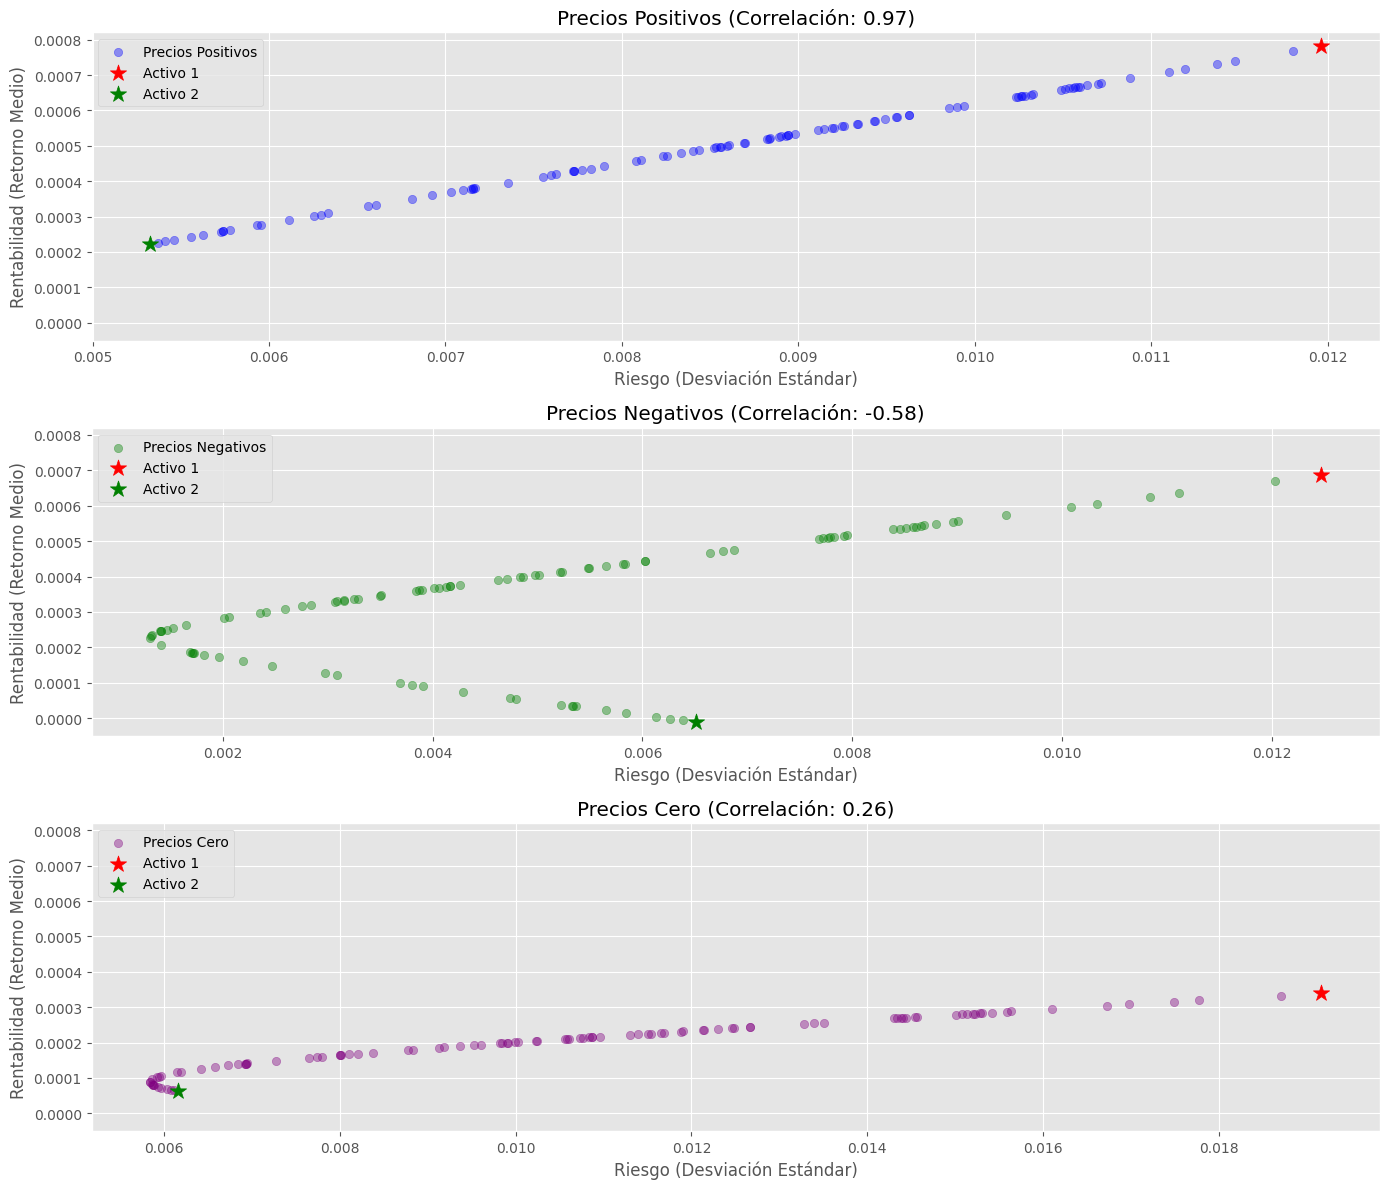

In [168]:
# Inicializar figura y ejes
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharey=True)

# Graficar en cada eje
plot_on_axis(axes[0], ret_pos_mean, ret_pos_std, asset1_pos_mean, asset1_pos_std, asset2_pos_mean, asset2_pos_std, 'blue', 'o', 'Precios Positivos', corr_pos)
plot_on_axis(axes[1], ret_neg_mean, ret_neg_std, asset1_neg_mean, asset1_neg_std, asset2_neg_mean, asset2_neg_std, 'green', 'o', 'Precios Negativos', corr_neg)
plot_on_axis(axes[2], ret_cero_mean, ret_cero_std, asset1_cero_mean, asset1_cero_std, asset2_cero_mean, asset2_cero_std, 'purple', 'o', 'Precios Cero', corr_cero)

plt.tight_layout()
plt.show()

<Axes: >

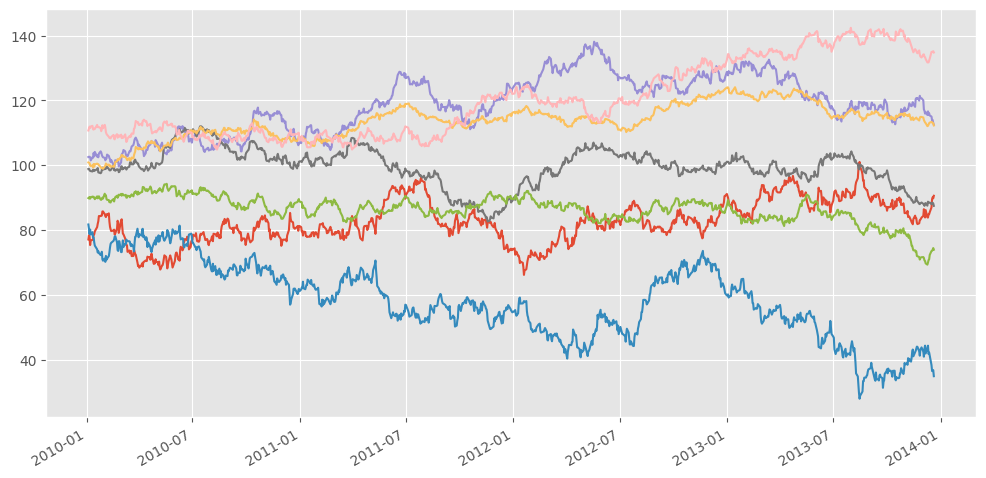

In [70]:


# Graficar rentabilidad vs. riesgo
plt.figure(figsize=(14, 7))

# Graficar carteras de precios_pos_df
plt.scatter(ret_pos_std, ret_pos_mean, c='blue', marker='o', label='Carteras Precios Positivos')

# Graficar carteras de precios_neg_df
plt.scatter(ret_neg_std, ret_neg_mean, c='green', marker='x', label='Carteras Precios Negativos')

# Graficar carteras de precios_cero_df
plt.scatter(ret_cero_std, ret_cero_mean, c='red', marker='s', label='Carteras Precios Cero')

# Configurar gráfico
plt.title('Rentabilidad vs. Riesgo de Carteras')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Rentabilidad (Retorno Medio)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
ret_df = np.log(precios_df).diff().dropna()

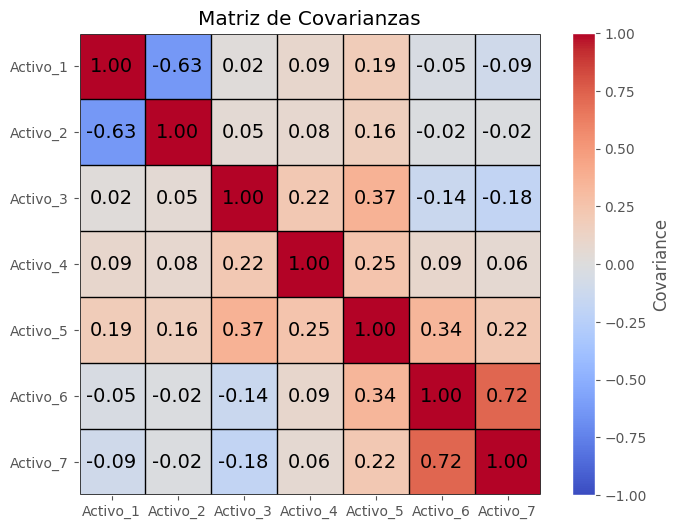

0

In [72]:
mat_corr = ret_df.corr()

dibuja_covar(mat_corr)

In [73]:
def calc_ret_cartera(w1, w2, r1, r2):
    return w1 * r1 + w2 * r2

def calc_std_cartera(w1, w2, std1, std2, rho):
    return np.sqrt(w1**2 * std1**2 + w2**2 * std2**2 + 2 * w1 * w2 * std1 * std2 * rho)

In [74]:
ret1 = ret_df.iloc[:, 0].mean()
ret2 = ret_df.iloc[:, 1].mean()

std1 = ret_df.iloc[:, 0].std()
std2 = ret_df.iloc[:, 1].std()

coef_corr = mat_corr.iloc[0, 1]


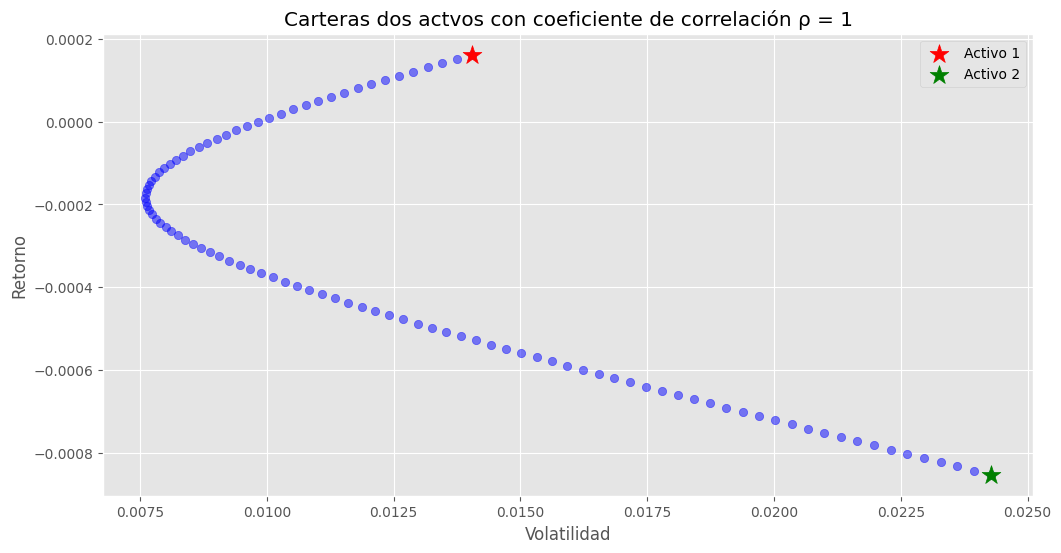

In [75]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.linspace(0, 1, 101) #generamos 101 puntos entre 0 y 1 que representan los pesos del activo 1

for i in x:
    reti = calc_ret_cartera(i, 1 - i, ret1, ret2) #calculamos el retorno de la cartera para cada peso
    stdi = calc_std_cartera(i, 1 - i, std1, std2, coef_corr) #calculamos la volatilidad de la cartera para cada peso
    plt.scatter(stdi, reti, color='blue', alpha=0.5) #marcamos el resto de puntos

plt.scatter(std1, ret1, color='red', marker='*', s=200, label='Activo 1') #marcamos el punto del activo 1
plt.scatter(std2, ret2, color='green', marker='*', s=200, label='Activo 2') #marcamos el punto del activo 2

plt.xlabel('Volatilidad')
plt.ylabel('Retorno')
plt.title('Carteras dos actvos con coeficiente de correlación \u03C1 = 1')
plt.legend()
plt.show()

In [76]:
activos = ret_df.iloc[:, 0:2]
activos.head(2)

,Activo_1,Activo_2
2010-01-05,0.017069,-0.015529
2010-01-06,-0.005315,-0.021200


In [77]:
pesos = np.random.uniform(0, 1, 200).reshape(-1, 2)
pesos = pesos / pesos.sum(axis=1, keepdims=True)


In [78]:
carteras = activos @ pesos.T

In [79]:
carteras.mean()

0    -0.000125
1    -0.000726
2    -0.000153
3    -0.000602
4     0.000017
        ...   
95   -0.000159
96   -0.000007
97   -0.000310
98    0.000072
99   -0.000147
Length: 100, dtype: float64

In [80]:
ret_med = carteras.mean()
ret_std = carteras.std()

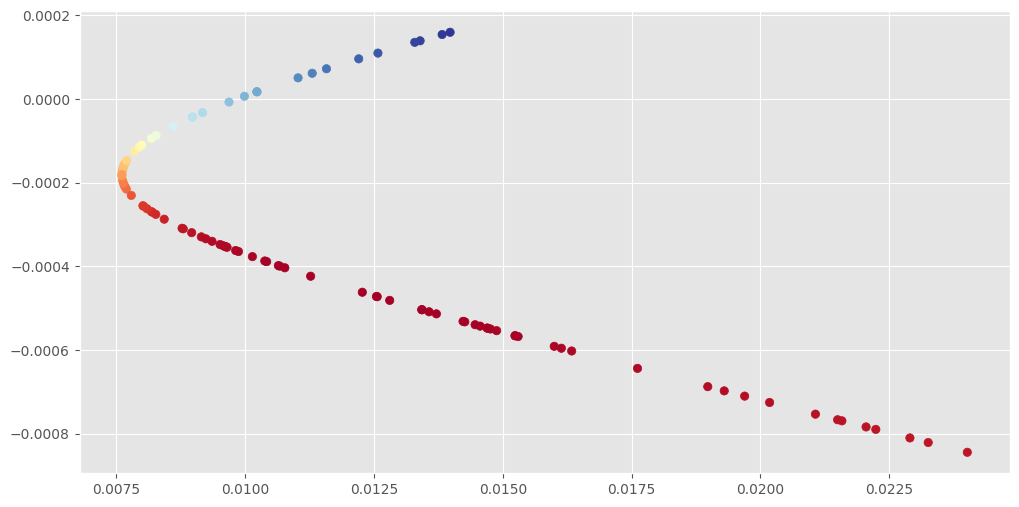

In [81]:
plt.figure(figsize=(12, 6))
plt.scatter(ret_std, ret_med, c=ret_med / ret_std, cmap='RdYlBu')

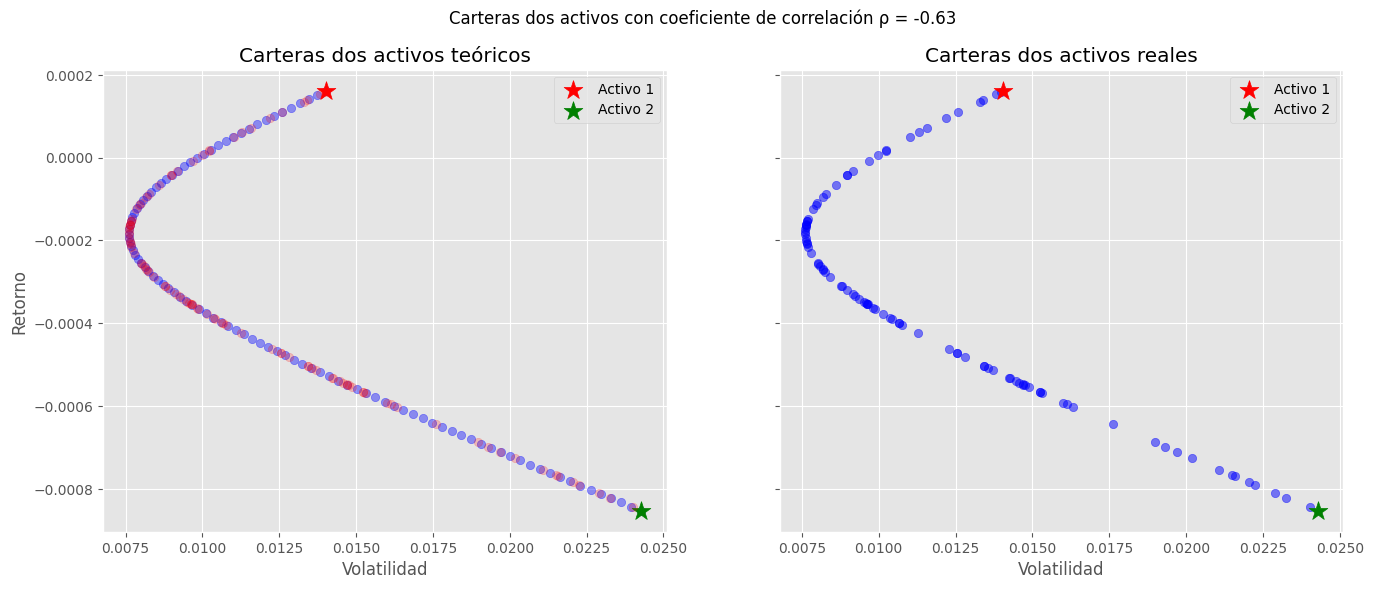

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)

x = np.linspace(0, 1, 101) #generamos 101 puntos entre 0 y 1 que representan los pesos del activo 1

for i in x:
    reti = calc_ret_cartera(i, 1 - i, ret1, ret2) #calculamos el retorno de la cartera para cada peso
    stdi = calc_std_cartera(i, 1 - i, std1, std2, coef_corr) #calculamos la volatilidad de la cartera para cada peso
    ax[0].scatter(stdi, reti, color='blue', alpha=0.4) 
    #plt.scatter(stdi, reti, color='blue', alpha=0.5, ax=ax[0]) #marcamos el resto de puntos

ax[0].scatter(std1, ret1, color='red', marker='*', s=200, label='Activo 1') #marcamos el punto del activo 1
ax[0].scatter(std2, ret2, color='green', marker='*', s=200, label='Activo 2') #marcamos el punto del activo 2
ax[0].legend()
ax[0].set_xlabel('Volatilidad')
ax[0].set_ylabel('Retorno')
ax[0].set_title('Carteras dos activos teóricos')
ax[0].scatter(ret_std, ret_med, c='red', alpha=0.2)


#ax[1].scatter(ret_std, ret_med, c=ret_med / ret_std, cmap='RdYlBu', alpha=0.5)
ax[1].scatter(ret_std, ret_med, c='blue', alpha=0.5)
ax[1].scatter(std1, ret1, color='red', marker='*', s=200, label='Activo 1') #marcamos el punto del activo 1
ax[1].scatter(std2, ret2, color='green', marker='*', s=200, label='Activo 2') #marcamos el punto del activo 2
ax[1].legend()
ax[1].set_xlabel('Volatilidad')
ax[1].set_title('Carteras dos activos reales')
#ax[1].set_ylabel('Retorno')

fig.suptitle(f'Carteras dos activos con coeficiente de correlación \u03C1 = {coef_corr:.2f}')
#plt.legend()
plt.show()

In [83]:
mat_corr.iloc[-2, -1]

0.7248184542013844

In [84]:
pesos = np.random.uniform(0, 1, 200).reshape(-1, 2)

In [85]:
pesos_2 = np.random.uniform(0, 1, 200).reshape(-1, 2)
pesos_2 = pesos_2 / pesos_2.sum(axis=1, keepdims=True)

In [86]:
activos = ret_df.iloc[:, 0:2]
activos.head(2)

,Activo_1,Activo_2
2010-01-05,0.017069,-0.015529
2010-01-06,-0.005315,-0.021200


In [87]:
activos_2 = ret_df.iloc[:, -2:]
activos_2.head(2)

,Activo_6,Activo_7
2010-01-05,-0.001472,0.005641
2010-01-06,0.005246,0.005070


In [89]:
carteras_2 = activos_2 @ pesos_2.T
carteras_2.shape

(999, 100)

In [90]:
ret_med_2 = carteras_2.mean()
ret_std_2 = carteras_2.std()

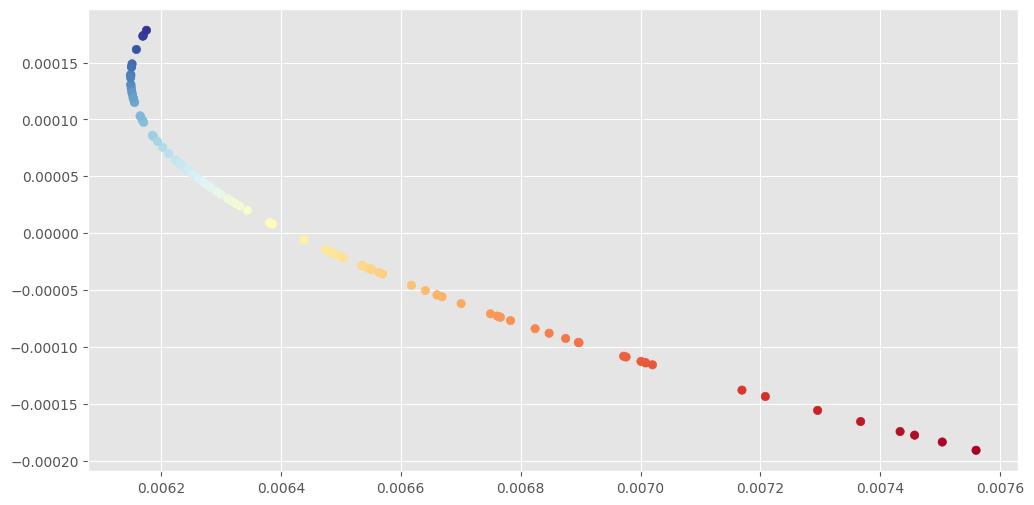

In [93]:
plt.figure(figsize=(12, 6))
plt.scatter(ret_std_2, ret_med_2, c=ret_med_2 / ret_std_2, cmap='RdYlBu')
#plt.scatter(ret_std, ret_med, c='blue', alpha=0.5)


In [11]:
ret1 = ret_df.iloc[:, 5].mean()
ret2 = ret_df.iloc[:, 6].mean()

std1 = ret_df.iloc[:, 5].std()
std2 = ret_df.iloc[:, 6].std()

coef_corr = mat_corr.iloc[0, -1]

In [12]:
coef_corr

-0.09386281252808257

In [104]:
med1 = 0.15/252
std1 = 0.3/np.sqrt(252)

med2 = 0.03/252
std2 = 0.1/np.sqrt(252)

corr12 = 1

num_dias = 1000

In [105]:
# Generar retornos diarios
np.random.seed(0)  # Fijar la semilla para reproducibilidad

# Generamos la matriz de covarianza
cov_matrix = np.array([[std1**2, corr12 * std1 * std2],
                       [corr12 * std1 * std2, std2**2]])

# Generamos los retornos
returns = np.random.multivariate_normal([med1, med2], cov_matrix, num_dias)

In [110]:
np.corrcoef(returns[:, 0], returns[:, 1])[0, 1]

0.9999999999999997

In [107]:
1 + returns.cumsum(axis=0)

array([[0.96725778, 0.98900656],
       [0.94935661, 0.98296014],
       [0.91465832, 0.97131468],
       ...,
       [2.00973496, 1.25737197],
       [1.98384389, 1.24866225],
       [2.00601904, 1.2559746 ]])

<Axes: >

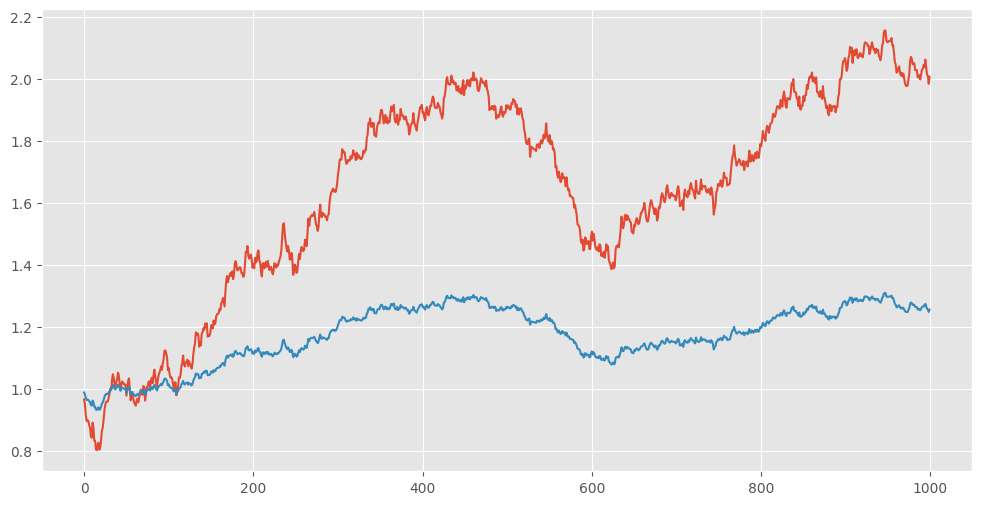

In [109]:
df_precios = 1 + returns.cumsum(axis=0)
df_precios = pd.DataFrame(df_precios, columns=['Activo 1', 'Activo 2'])
df_precios.plot(figsize=(12, 6), legend=False)